<a href="https://colab.research.google.com/github/yexf308/MachineLearning/blob/main/Module3/Optimization_and_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline 
import pandas as pd
from scipy import linalg
from itertools import combinations
import scipy
import torch

Populating the interactive namespace from numpy and matplotlib


$\def\m#1{\mathbf{#1}}$
$\def\mm#1{\boldsymbol{#1}}$
$\def\mb#1{\mathbb{#1}}$
$\def\c#1{\mathcal{#1}}$
$\def\mr#1{\mathrm{#1}}$
$\newenvironment{rmat}{\left[\begin{array}{rrrrrrrrrrrrr}}{\end{array}\right]}$
$\newcommand\brm{\begin{rmat}}$
$\newcommand\erm{\end{rmat}}$
$\newenvironment{cmat}{\left[\begin{array}{ccccccccc}}{\end{array}\right]}$
$\newcommand\bcm{\begin{cmat}}$
$\newcommand\ecm{\end{cmat}}$


This notebook is based on chapter 12 in Dive into deep learning. 

In deep learning, most objective functions are complicated and do not have analytical solutions. Instead, we must use numerical optimization algorithms. There are many challenges in deep learning optimization.

- **Local Minima**: For example, given the function
$$f(x) = x \cdot \text{cos}(\pi x) \text{ for } -1.0 \leq x \leq 2.0,$$
we can approximate the local minimum and global minimum of this function.

 The objective function of deep learning models usually has many local optima.
When the numerical solution of an optimization problem is near the local optimum, the numerical solution obtained by the final iteration may only minimize the objective function *locally*, rather than *globally*, as the gradient of the objective function's solutions approaches or becomes zero.
Only some degree of noise might knock the parameter out of the local minimum. In fact, this is one of the beneficial properties of
minibatch stochastic gradient descent where the natural variation of gradients over minibatches is able to dislodge the parameters from local minima.



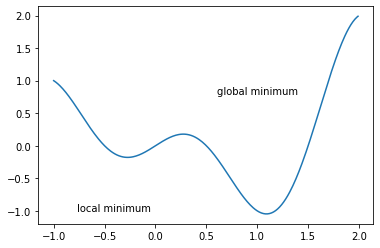

In [2]:
def f(x):
    return x * torch.cos(np.pi * x)

x = torch.arange(-1.0, 2.0, 0.01)
plt.plot(x, f(x))
plt.annotate('local minimum', (-0.3, -0.25), (-0.77, -1.0))
plt.annotate('global minimum', (1.1, -0.95), (0.6, 0.8))
plt.show()

### Saddle Points

Besides local minima, saddle points are another reason for gradients to vanish. A *saddle point* is any location where all gradients of a function vanish but which is neither a global nor a local minimum.

Saddle points in higher dimensions are even more insidious, as the example below shows. Consider the function $f(x, y) = x^2 - y^2$. It has its saddle point at $(0, 0)$. This is a maximum with respect to $y$ and a minimum with respect to $x$.


/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


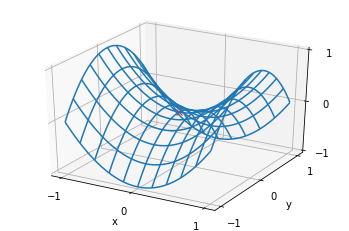

In [3]:
x, y = torch.meshgrid(
    torch.linspace(-1.0, 1.0, 101), torch.linspace(-1.0, 1.0, 101))
z = x**2 - y**2

ax = plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 10, 'cstride': 10})
ax.plot([0], [0], [0], 'rx')
ticks = [-1, 0, 1]
plt.xticks(ticks)
plt.yticks(ticks)
ax.set_zticks(ticks)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We assume that the input of a function is a $k$-dimensional vector and its
output is a scalar, so its Hessian matrix will have $k$ eigenvalues.
The solution of the
function could be a local minimum, a local maximum, or a saddle point at a
position where the function gradient is zero:

* When the eigenvalues of the function's Hessian matrix at the zero-gradient position are all positive, we have a local minimum for the function.
* When the eigenvalues of the function's Hessian matrix at the zero-gradient position are all negative, we have a local maximum for the function.
* When the eigenvalues of the function's Hessian matrix at the zero-gradient position are negative and positive, we have a saddle point for the function.


For high-dimensional problems the likelihood that at least *some* of the eigenvalues are negative is quite high. This makes saddle points more likely than local minima.

### Vanishing Gradients

Probably the most insidious problem to encounter is the vanishing gradient.
Recall our commonly-used activation functions and their derivatives in :numref:`subsec_activation-functions`.
For instance, assume that we want to minimize the function $f(x) = \tanh(x)$ and we happen to get started at $x = 4$. As we can see, the gradient of $f$ is close to nil.
More specifically, $f'(x) = 1 - \tanh^2(x)$ and thus $f'(4) = 0.0013$.
Consequently, optimization will get stuck for a long time before we make progress. This turns out to be one of the reasons that training deep learning models was quite tricky prior to the introduction of the ReLU activation function.

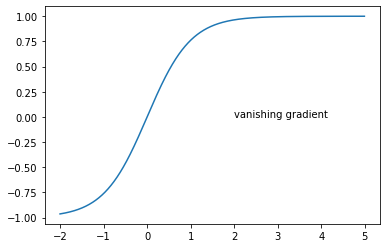

In [4]:
x = torch.arange(-2.0, 5.0, 0.01)
plt.plot(x, torch.tanh(x))
plt.annotate('vanishing gradient', (4, 1), (2, 0.0))
plt.show()

# 1. Stochastic Gradient Descent 
We have covered enough in this course. 

$$
\begin{aligned}
    \eta_t & = \eta_i \text{ if } t_i \leq t \leq t_{i+1}  && \text{piecewise constant} \\
    \eta_t & = \eta_0 \cdot (\beta t + 1)^{-\alpha} && \text{polynomial decay}
\end{aligned}
$$

- In the first *piecewise constant* scenario we decrease the learning rate, e.g., whenever progress in optimization stalls. This is a common strategy for training deep networks. 

- For *polynomial decay* with $\alpha = 0.5$, in the case of convex optimization there are a number of proofs that show that this rate is well behaved.


# 2. Minibatch Stochastic Gradient Descent
- Gradient descent is not particularly *data efficient* whenever data is very similar.
- Stochastic gradient descent is not particularly *computationally efficient* since CPUs and GPUs cannot exploit the full power of vectorization.

Minibatch SGD can fully utilize the power of vectorization. 
In each epoch, randomly sample mini-batch $\mathcal{B}_t\subset \{1,\dots, N\}$ of fixed size $|\mathcal{B}_t|$.

Evaluate and sum up and average gradient of sample loss functions: 
$$ \mathbf{w}_{t+1}=\mathbf{w}_t-\frac{\eta_t}{|\mathcal{B}_t|} \sum_{i\in \mathcal{B}_t}\nabla f(\m{x}^{(i)}, \m{w}_t)$$ 
Minibatch SGD in fact reduces the amount of variance by averaging gradients. 

In practice we pick a minibatch $\mathcal{B}_t$ that is large enough to offer good computational efficiency while still fitting into the memory of a GPU. 

### Example: airfoil dataset

In [5]:
!wget https://github.com/yexf308/MAT592/blob/main/data/airfoil_self_noise.dat?raw=true -O airfoil_self_noise.dat


--2022-11-11 17:35:58--  https://github.com/yexf308/MAT592/blob/main/data/airfoil_self_noise.dat?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/yexf308/MachineLearning/blob/main/data/airfoil_self_noise.dat?raw=true [following]
--2022-11-11 17:35:58--  https://github.com/yexf308/MachineLearning/blob/main/data/airfoil_self_noise.dat?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/yexf308/MachineLearning/raw/main/data/airfoil_self_noise.dat [following]
--2022-11-11 17:35:59--  https://github.com/yexf308/MachineLearning/raw/main/data/airfoil_self_noise.dat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yexf308/MachineLearning/main/data/airfoi

In [6]:
data = np.genfromtxt('airfoil_self_noise.dat',
                         dtype=np.float32, delimiter='\t')
#data = torch.from_numpy(data)
data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
X    = data[:1500, :-1]
y    = data[:1500, -1]

Training models consists of making multiple passes over the dataset, grabbing one minibatch of examples at a time, and using them to update our model. Since this process is so fundamental to training machine learning algorithms, it is worth defining a utility function to shuffle the dataset and access it in minibatches.

In general, note that we want to use reasonably sized minibatches to take advantage of the GPU hardware, which excels at parallelizing operations. Because each example can be fed through our models in parallel and the gradient of the loss function for each example can also be taken in parallel, GPUs allow us to process hundreds of examples in scarcely more time than it might take to process just a single example.

In [7]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [8]:
feature_dim = X.shape[1]
w = torch.normal(0, 0.05, size=(feature_dim,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

def linreg(X, w, b):  
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):  
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2    


def sgd(params, lr, batch_size):  
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for w in params:
            w -= lr * w.grad / batch_size
            w.grad.zero_()
     


In [9]:
lr = 0.03
num_epochs = 20
net = linreg
loss = squared_loss
batch_size = 10

In [10]:
print(f'epoch {0}, loss {float(loss(net(X, w, b), y).mean()):f}')

for epoch in range(num_epochs):
    for Xi, yi in data_iter(batch_size, X, y):
        l = loss(net(Xi, w, b), yi)  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
   
    train_l = loss(net(X, w, b), y)
    print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 0, loss 0.526335
epoch 1, loss 0.245988
epoch 2, loss 0.245064
epoch 3, loss 0.242810
epoch 4, loss 0.242441
epoch 5, loss 0.242419
epoch 6, loss 0.242765
epoch 7, loss 0.243516
epoch 8, loss 0.244819
epoch 9, loss 0.242983
epoch 10, loss 0.242214
epoch 11, loss 0.243701
epoch 12, loss 0.243543
epoch 13, loss 0.244780
epoch 14, loss 0.245101
epoch 15, loss 0.242630
epoch 16, loss 0.241874
epoch 17, loss 0.245391
epoch 18, loss 0.242510
epoch 19, loss 0.243267
epoch 20, loss 0.242787


In [11]:
num_epochs =2
w = torch.normal(0, 0.1, size=(feature_dim,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
N = int(X.shape[0]/batch_size)*num_epochs +1

loss_store = [loss(net(X, w, b), y).mean().detach().numpy()]
for epoch in range(num_epochs):
    for Xi, yi in data_iter(batch_size, X, y):
        l = loss(net(Xi, w, b), yi)  # Minibatch loss in `X` and `y`
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
        loss_store.append(loss(net(X, w, b), y).mean().detach().numpy())
        
loss_store = np.array(loss_store)


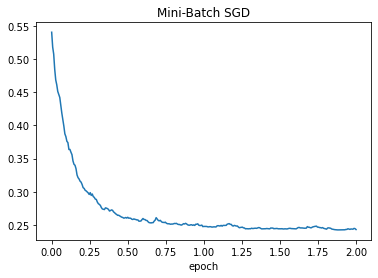

In [12]:
epoch_list = np.linspace(0, num_epochs, N)
ax = plt.gca()
ax.plot(epoch_list, loss_store)
ax.set_xlabel('epoch')
ax.set_title('Mini-Batch SGD')
plt.show()


# 3. Momentum

The method is described as follows.
$$
\begin{aligned}
\mathbf{v}_t &\leftarrow \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}, \\
\mathbf{x}_t &\leftarrow \mathbf{x}_{t-1} - \eta_t \mathbf{v}_t.
\end{aligned}
$$

Note that for $\beta = 0$ we recover regular gradient descent. $\mathbf{v}$ is the momentum. 

Equivalently, with the recursive argument

$$\begin{aligned}
\mathbf{v}_t = \beta^2 \mathbf{v}_{t-2} + \beta \mathbf{g}_{t-1, t-2} + \mathbf{g}_{t, t-1}
= \ldots, = \sum_{\tau = 0}^{t-1} \beta^{\tau} \mathbf{g}_{t-\tau, t-\tau-1}.
\end{aligned}$$
where 
large $\beta$ amounts to a long-range average, whereas small $\beta$ amounts to only a slight correction relative to a gradient method. This accelerates convergence significantly.

In the limit the terms add up to $\sum_{\tau=0}^\infty \beta^\tau = \frac{1}{1-\beta}$. In other words, rather than taking a step of size $\eta$ in gradient descent or stochastic gradient descent we take a step of size $\frac{\eta}{1-\beta}$ while at the same time, dealing with a potentially much better behaved descent direction. 


More theoretical analysis, please see [here](https://distill.pub/2017/momentum/). 


### Summary

* Momentum replaces gradients with a leaky average over past gradients. This accelerates convergence significantly.
* It is desirable for both noise-free gradient descent and (noisy) stochastic gradient descent.
* Momentum prevents stalling of the optimization process that is much more likely to occur for stochastic gradient descent.
* The effective number of gradients is given by $\frac{1}{1-\beta}$ due to exponentiated downweighting of past data.
* In the case of convex quadratic problems this can be analyzed explicitly in detail.
* Implementation is quite straightforward but it requires us to store an additional state vector (momentum $\mathbf{v}$).




In [13]:
# implement from scratch
def sgd_momentum(params, states, lr, momentum,batch_size):
    for w, v in zip(params, states):
        with torch.no_grad():
            v[:] =  momentum * v + w.grad/batch_size
            w[:] -= lr * v
        w.grad.data.zero_()

In [14]:
lr = 0.005
momentum = 0.9
num_epochs = 2
net = linreg
loss = squared_loss
batch_size = 10

v_w = torch.zeros((feature_dim, 1))   #<--
v_b = torch.zeros(1)        #<--

w = torch.normal(0, 0.1, size=(feature_dim,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
N = int(X.shape[0]/batch_size)*num_epochs +1

loss_store = [loss(net(X, w, b), y).mean().detach().numpy()]
for epoch in range(num_epochs):
    for Xi, yi in data_iter(batch_size, X, y):
        l = loss(net(Xi, w, b), yi).sum()  
        l.backward()
        sgd_momentum([w, b], [v_w, v_b], lr, momentum, batch_size)  #<--
        loss_store.append(loss(net(X, w, b), y).mean().detach().numpy())
        
loss_store = np.array(loss_store)

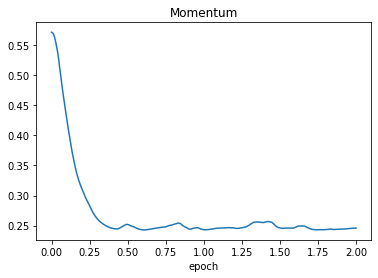

In [15]:
epoch_list = np.linspace(0, num_epochs, N)
ax = plt.gca()
ax.plot(epoch_list, loss_store)
ax.set_xlabel('epoch')
ax.set_title('Momentum')
plt.show()

In [16]:
# use package in pytorch
import torch.optim as optim
lr = 0.001
momentum = 0.9
num_epochs = 2
net = linreg
loss = squared_loss
batch_size = 10


w = torch.normal(0, 0.1, size=(feature_dim,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
N = int(X.shape[0]/batch_size)*num_epochs +1


optimizer = optim.SGD([w,b], lr=lr, momentum=momentum) #<--


loss_store = [loss(net(X, w, b), y).mean().detach().numpy()]
for epoch in range(num_epochs):
    for Xi, yi in data_iter(batch_size, X, y):
        optimizer.zero_grad()   #<--
        l = loss(net(Xi, w, b), yi).sum()
        l.backward()
        optimizer.step()         #<--
        loss_store.append(loss(net(X, w, b), y).mean().detach().numpy())
        
loss_store = np.array(loss_store)

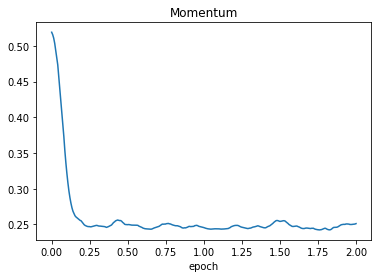

In [17]:
epoch_list = np.linspace(0, num_epochs, N)
ax = plt.gca()
ax.plot(epoch_list, loss_store)
ax.set_xlabel('epoch')
ax.set_title('Momentum')
plt.show()

# 4.AdaGrad
If your feature is sparse, i.e., features that occur only infrequently. This is common for natural language. 

Parameters associated with infrequent features only receive meaningful updates whenever these features occur. Given a decreasing learning rate we might end up in a situation where the parameters for common features converge rather quickly to their optimal values, whereas for infrequent features we are still short of observing them sufficiently frequently before their optimal values can be determined. In other words, the learning rate either decreases too slowly for frequent features or too quickly for infrequent ones.

A possible hack to redress this issue would be to count the number of times we see a particular feature and to use this as a clock for adjusting learning rates. That is, rather than choosing a learning rate of the form $\eta = \frac{\eta_0}{\sqrt{t + c}}$ we could use $\eta_i = \frac{\eta_0}{\sqrt{s(i, t) + c}}$. Here $s(i, t)$ counts the number of nonzeros for feature $i$ that we have observed up to time $t$. However, it fails whenever we do not quite have sparsity but rather just data where the gradients are often very small and only rarely large. After all, it is unclear where one would draw the line between something that qualifies as an observed feature or not.

In AdaGrad, we use
$s(i, t+1) = s(i, t) + \left(\partial_i f(\mathbf{x})\right)^2$ as a means to adjust the learning rate. 

- We no longer need to decide just when a gradient is large enough.

- It scales automatically with the magnitude of the gradients. Coordinates that routinely correspond to large gradients are scaled down significantly, whereas others with small gradients receive a much more gentle treatment.


## The Algorithm

Let's formalize the discussion from above. We use the variable $\mathbf{s}_t$ to accumulate past gradient variance as follows.

$$\begin{aligned}
    \mathbf{g}_t & = \partial_{\mathbf{w}} l(y_t, f(\mathbf{x}_t, \mathbf{w})), \\
    \mathbf{s}_t & = \mathbf{s}_{t-1} + \mathbf{g}_t^2, \\
    \mathbf{w}_t & = \mathbf{w}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \cdot \mathbf{g}_t.
\end{aligned}$$
Here the operation are applied coordinate wise.

## Summary

* Adagrad decreases the learning rate dynamically on a per-coordinate basis.
* It uses the magnitude of the gradient as a means of adjusting how quickly progress is achieved - coordinates with large gradients are compensated with a smaller learning rate.
* If the optimization problem has a rather uneven structure Adagrad can help mitigate the distortion.
* Adagrad is particularly effective for sparse features where the learning rate needs to decrease more slowly for infrequently occurring terms.
* On deep learning problems Adagrad can sometimes be too aggressive in reducing learning rates.


In [18]:
# implement from scratch
def adagrad(params, states, lr, batch_size):
    eps = 1e-6
    for w, s in zip(params, states):
        with torch.no_grad():
            s[:] += torch.square(w.grad/batch_size)
            w[:] -= lr * (w.grad/batch_size) / torch.sqrt(s + eps)
        w.grad.data.zero_()

In [19]:
lr = 0.1        #<--
num_epochs = 2
net = linreg
loss = squared_loss
batch_size = 10

s_w = torch.zeros((feature_dim, 1))   
s_b = torch.zeros(1)        

w = torch.normal(0, 0.1, size=(feature_dim,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
N = int(X.shape[0]/batch_size)*num_epochs +1

loss_store = [loss(net(X, w, b), y).mean().detach().numpy()]
for epoch in range(num_epochs):
    for Xi, yi in data_iter(batch_size, X, y):
        l = loss(net(Xi, w, b), yi)  
        l.sum().backward()
        adagrad([w, b], [s_w, s_b], lr,  batch_size)  #<--
        loss_store.append(loss(net(X, w, b), y).mean().detach().numpy())
        
loss_store = np.array(loss_store)

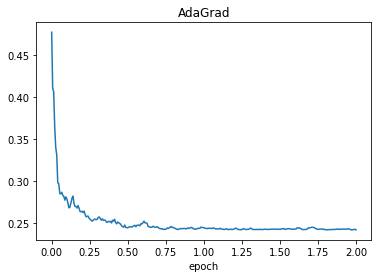

In [20]:
epoch_list = np.linspace(0, num_epochs, N)
ax = plt.gca()
ax.plot(epoch_list, loss_store)
ax.set_xlabel('epoch')
ax.set_title('AdaGrad')
plt.show()

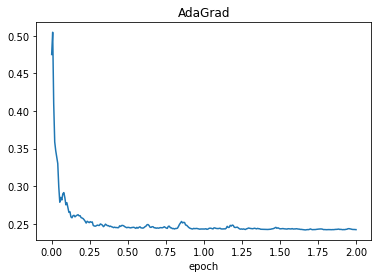

In [21]:
# use package in pytorch 
w = torch.normal(0, 0.1, size=(feature_dim,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

optimizer = optim.Adagrad([w,b], lr=lr) #<--

loss_store = [loss(net(X, w, b), y).mean().detach().numpy()]
for epoch in range(num_epochs):
    for Xi, yi in data_iter(batch_size, X, y):
        optimizer.zero_grad()   #<--
        l = loss(net(Xi, w, b), yi).sum()
        l.backward()
        optimizer.step()         #<--
        loss_store.append(loss(net(X, w, b), y).mean().detach().numpy())
        
loss_store = np.array(loss_store)

epoch_list = np.linspace(0, num_epochs, N)
ax = plt.gca()
ax.plot(epoch_list, loss_store)
ax.set_xlabel('epoch')
ax.set_title('AdaGrad')
plt.show()

# 5.RMSProp
In AdaGrad, one can show the learning rate decreases at a predefined schedule of effectively $O(1/\sqrt{t})$. While this is generally appropriate for convex problems, it might not be ideal for nonconvex ones, such as those encountered in deep learning. Yet, the coordinate-wise adaptivity of Adagrad is highly desirable as a preconditioner. 

The method is to use a leaky average in the same way we used in the momentum method, i.e., $\mathbf{s}_t \leftarrow \gamma \mathbf{s}_{t-1} + (1-\gamma) \mathbf{g}_t^2$ for some parameter $\gamma > 0$. Keeping all other parts unchanged yields RMSProp.

\begin{align}
    \mathbf{s}_t & \leftarrow \gamma \mathbf{s}_{t-1} + (1 - \gamma) \mathbf{g}_t^2, \\
    \mathbf{x}_t & \leftarrow \mathbf{x}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \odot \mathbf{g}_t.
\end{align}
The constant $\epsilon > 0$ is typically set to $10^{-6}$ to ensure that we do not suffer from division by zero or overly large step sizes. Given this expansion we are now free to control the learning rate $\eta$ independently of the scaling that is applied on a per-coordinate basis. 

In [22]:
def rmsprop(params, states, lr, gamma, batch_size):
    eps = 1e-6
    for w, s in zip(params, states):
        with torch.no_grad():
            s[:] = gamma * s + (1 - gamma) * torch.square(w.grad/batch_size)
            w[:] -= lr * (w.grad/batch_size) / torch.sqrt(s + eps)
        w.grad.data.zero_()

In [23]:
lr = 0.01
gamma = 0.9  # <--
num_epochs = 2
net = linreg
loss = squared_loss
batch_size = 10

s_w = torch.zeros((feature_dim, 1))   
s_b = torch.zeros(1)        

w = torch.normal(0, 0.1, size=(feature_dim,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
N = int(X.shape[0]/batch_size)*num_epochs +1

loss_store = [loss(net(X, w, b), y).mean().detach().numpy()]
for epoch in range(num_epochs):
    for Xi, yi in data_iter(batch_size, X, y):
        l = loss(net(Xi, w, b), yi)  
        l.sum().backward()
        rmsprop([w, b], [s_w, s_b], lr, gamma, batch_size)  #<--
        loss_store.append(loss(net(X, w, b), y).mean().detach().numpy())
        
loss_store = np.array(loss_store)

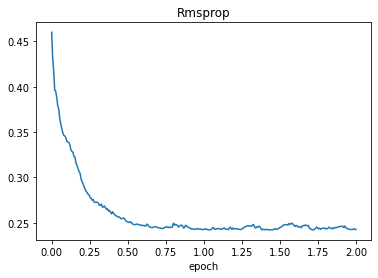

In [24]:
epoch_list = np.linspace(0, num_epochs, N)
ax = plt.gca()
ax.plot(epoch_list, loss_store)
ax.set_xlabel('epoch')
ax.set_title('Rmsprop')
plt.show()

# 6. AdaDelta

Adadelta is a variant of AdaGrad. The main difference lies in the fact that it decreases the amount by which the learning rate is adaptive to coordinates.

Adadelta uses two state variables:

- $\mathbf{s}_t$: to store a leaky average of the second moment of the gradient. 

- $\Delta\mathbf{x}_t$: to store a leaky average of the second moment of the change of parameters. 

The algorithm gives as follows, the leaky update is similar with Rmsprop. 
\begin{align}
 \mathbf{s}_t & = \rho \mathbf{s}_{t-1} + (1 - \rho) \mathbf{g}_t^2 \\
  \mathbf{x}_t  & = \mathbf{x}_{t-1} - \frac{\sqrt{\Delta\mathbf{x}_{t-1} + \epsilon}}{\sqrt{{\mathbf{s}_t + \epsilon}}} \odot \mathbf{g}_t
\end{align}
where $\Delta \mathbf{x}_{t-1}$ is the leaky average of the squared rescaled gradients $\mathbf{g}_t'$. We initialize $\Delta \mathbf{x}_{0}$ to be $0$ and update it at each step with $\mathbf{g}_t'$, i.e.,

\begin{align}
    \Delta \mathbf{x}_t & = \rho \Delta\mathbf{x}_{t-1} + (1 - \rho) {\mathbf{g}_t'}^2,
\end{align}
and $\epsilon$ (a small value such as $10^{-5}$) is added to maintain numerical stability. Choosing $\rho = 0.9$ amounts to a half-life time of 10 for each parameter update.

In [25]:
def adadelta(params, states, rho, batch_size):
    eps = 1e-6
    for w, (s, delta) in zip(params, states):
        s[:] = rho * s + (1 - rho) * np.square(w.grad)
        g = (np.sqrt(delta + eps) / np.sqrt(s + eps)) * w.grad
        w[:] -= g
        delta[:] = rho * delta + (1 - rho) * g * g

In [26]:
s_w, s_b          = np.zeros((feature_dim, 1)), np.zeros(1)
delta_w, delta_b  = np.zeros((feature_dim, 1)), np.zeros(1)



# 7. Adam
ADAM combines all these techniques into one efficient learning algorithm. As expected, this is an algorithm that has become rather popular as one of the more robust and effective optimization algorithms to use in deep learning.

The algorithm is given as follows,

One of the key components of Adam is that it uses exponential weighted moving averages (also known as leaky averaging) to obtain an estimate of both the momentum and also the second moment of the gradient. That is, it uses the state variables

\begin{align}
    \mathbf{v}_t & = \beta_1 \mathbf{v}_{t-1} + (1 - \beta_1) \mathbf{g}_t, \\
    \mathbf{s}_t & = \beta_2 \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2, \\
    \hat{\mathbf{v}}_t &= \frac{\mathbf{v}_t}{1 - \beta_1^t} \\
   \hat{\mathbf{s}}_t &= \frac{\mathbf{s}_t}{1 - \beta_2^t} \\
    \mathbf{g}_t' &= \frac{\eta \hat{\mathbf{v}}_t}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}, \\
    \mathbf{x}_t &= \mathbf{x}_{t-1} - \mathbf{g}_t'
\end{align}
Common choices for parameters are $\beta_1 = 0.9, \beta_2 = 0.999, \epsilon = 10^{-6} $.


In [ ]:
def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

In [ ]:
v_w, v_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)

## Yogi 
One of the problems of Adam is that it can fail to converge even in convex settings when the second moment estimate in $\mathbf{s}_t$ blows up.

To understand what's going on, let's rewrite the Adam update as follows:

$$\mathbf{s}_t = \mathbf{s}_{t-1} + (1 - \beta_2) \left(\mathbf{g}_t^2 - \mathbf{s}_{t-1}\right).$$

Whenever $\mathbf{g}_t^2$ has high variance or updates are sparse, $\mathbf{s}_t$ might forget past values too quickly. A possible fix for this is to replace $\mathbf{g}_t^2 - \mathbf{s}_{t-1}$ by $\mathbf{g}_t^2 \odot \mathop{\mathrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1})$. Now the magnitude of the update no longer depends on the amount of deviation. This yields the Yogi updates

$$\mathbf{s}_t = \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2 \odot \mathop{\mathrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1}).$$



In [ ]:
def yogi(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-3
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = s + (1 - beta2) * torch.sign(
                torch.square(p.grad) - s) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1
